In [1]:
from src.datamodules.components.focus_dataset import FocusDataset
from src.datamodules.focus_datamodule import FocusDataModule, Transformation
from omegaconf import OmegaConf
import yaml
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchmetrics import MeanAbsoluteError

In [17]:
path_to_model = "/home/maf4031/focus_model/outputs/model.pt"
path_to_dataset = "/home/maf4031/focus_model/data/datasets/dataset_subsample100_complete.pt"
path_to_yaml = "/home/maf4031/focus_model/configs/datamodule/mobilenetv3.yaml"

In [18]:
transforms_dict = OmegaConf.create(yaml.load(open(path_to_yaml, "r"), Loader=yaml.FullLoader))
transforms_dict.transformations.params.resize_img = True
tranforms = Transformation(transforms_dict["transformations"]["params"])
tranforms.transforms

Compose(
    ToTensor()
    Resize(size=(216, 384), interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=0, std=1)
)

In [19]:
data_module = FocusDataModule(
    data_dir="",
    dataset_dir=path_to_dataset,
    subsample=True,
    subsample_size=100,
    select_patches_grid=False,
    batch_size=1,
    num_workers=0,
    pin_memory=False,
    splits=(0.8, 0.1, 0.1),
    transformations=tranforms,
    )
data_module.setup()

In [20]:
data_module.transforms.transforms

Compose(
    ToTensor()
    Resize(size=(216, 384), interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=0, std=1)
)

In [21]:
model = torch.jit.load(path_to_model, map_location="cuda")
_ = model.eval()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
errors = []

test_data = iter(data_module.test_dataloader())
run = False
if device.type == "cuda" and run:
    error_metric = MeanAbsoluteError().to(device)
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_data):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            errors.append(error_metric(y_hat, y))
            predictions.append((y, y_hat))
    pred_cpu = [(pred[0].to("cpu"), pred[1].to("cpu")) for pred in predictions]
    np.save("outputs/predictions.npy", pred_cpu)

predictions = np.load("outputs/predictions.npy", allow_pickle=True)

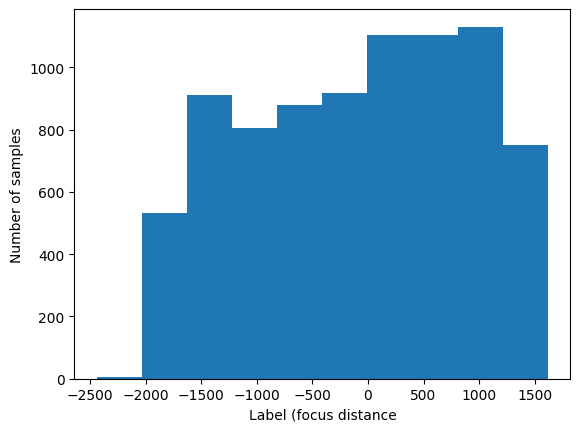

In [25]:
# plot label distribution
labels = [p[0].item() for p in predictions]
plt.hist(labels)
plt.xlabel("Label (focus distance")
plt.ylabel("Number of samples")
plt.show()

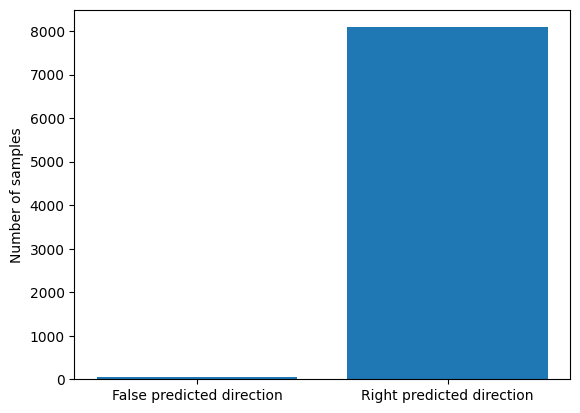

Number of false predicted directions: 53
Percentage of false predicted directions: 0.7%


In [26]:
false_direction_predictions = []
for pred in predictions:
    if np.sign(pred[0].item()) != np.sign(pred[1].item()):
        false_direction_predictions.append(pred)
plt.bar(["False predicted direction", "Correct predicted direction"], [len(false_direction_predictions), len(predictions)-len(false_direction_predictions)])
plt.ylabel("Number of samples")
plt.show()
print(f"Number of false predicted directions: {len(false_direction_predictions)}")
print(f"Percentage of false predicted directions: {len(false_direction_predictions)/len(predictions)*100:.1f}%")

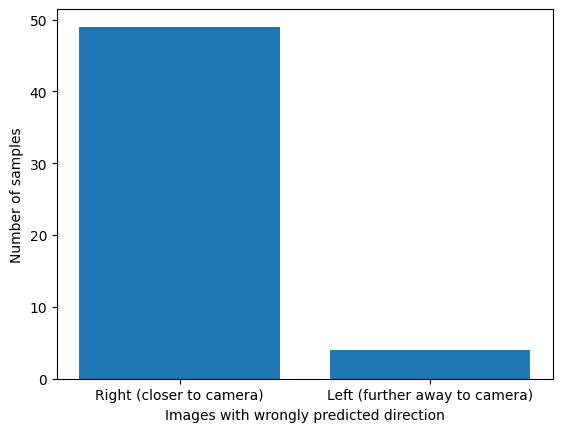

Mean value of focus distance of samples with false predicted direction: 0.9μm
Max value of focus distance of samples with false predicted direction: 13.6μm
7.55% of predictions are negative (right side of optimal focus point).
Model seems to have more issues predicting the correct positions from images further away from the camera.


In [37]:
mean_y = np.mean([abs(y.item()) for y, y_hat in false_direction_predictions])
max_y = np.max([abs(y.item()) for y, y_hat in false_direction_predictions])
std_y = np.std([abs(y.item()) for y, y_hat in false_direction_predictions])
neg_y = [y.item() for y, y_hat in false_direction_predictions if y.item() < 0]

plt.bar(["Right (closer to camera)", "Left (further away to camera)"], [len(false_direction_predictions)-len(neg_y), len(neg_y)])
plt.xlabel("Images with wrongly predicted direction")
plt.ylabel("Number of samples")
plt.show()

print(f"Mean value of focus distance of samples with false predicted direction: {mean_y:.1f}μm")
print(f"Max value of focus distance of samples with false predicted direction: {max_y:.1f}μm")
print(f"{len(neg_y)/len(false_direction_predictions)*100:.2f}% of predictions are negative (right side of optimal focus point).")
print("Model seems to have more issues predicting the correct positions from images further away from the camera.")

In [28]:
# depth of field of microscope
_lambda = 0.55
na = 0.1
m = 4
e = 1.55
n = 1

dof = (_lambda/na**2)+(e/(m*na))
print(f"Depth of field: {dof:.2f} μm")

Depth of field: 58.87 μm


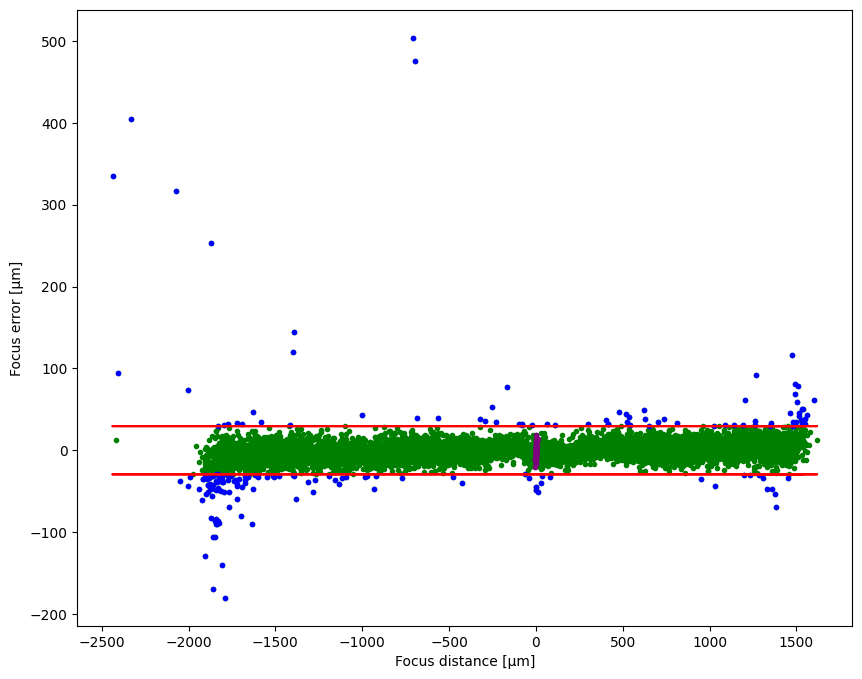

Overall average focus error: 8.87 μm
Average focus error for images further away from the camera: 9.77 μm
Average focus error for images closer to the camera: 7.98 μm
Percentage of predictions outside of the depth of field: 2.38%


In [58]:
focus_errors = [float(y.item() - y_hat.item()) for y, y_hat in predictions]
focus_errors_left = [float(y.item() - y_hat.item()) for y, y_hat in predictions if y.item() < 0]
focus_errors_right = [float(y.item() - y_hat.item()) for y, y_hat in predictions if y.item() > 0]
focus_errors_ouside_dof = [float(y.item() - y_hat.item()) for y, y_hat in predictions if abs(float(y.item() - y_hat.item())) > dof/2]

plt.figure(figsize=(10, 8))
plt.plot(list(zip(*predictions))[0], focus_errors, ".", color="g", label="All predictions", ls="None")
for idx in range(len(predictions)):
    if np.sign(predictions[idx][0].item()) != np.sign(predictions[idx][1].item()):
        plt.plot(predictions[idx][0].item(), focus_errors[idx], ".", color="purple", label="False predicted direction", ls="None")
    if abs(focus_errors[idx]) > dof/2:
        plt.plot(predictions[idx][0].item(), focus_errors[idx], ".", color="b", label="Prediction out of DOF", ls="None")
plt.plot(list(zip(*predictions))[0], np.ones(len(predictions))*dof/2, color="r", linestyle="-", label="DOF")
plt.plot(list(zip(*predictions))[0], np.ones(len(predictions))*(-dof/2), color="r", linestyle="-")
plt.xlabel("Focus distance [μm]")
plt.ylabel("Focus error [μm]")
#plt.legend()
plt.show()

print("Overall average focus error: {:.2f} μm".format(np.mean(np.abs(focus_errors))))
print("Average focus error for images further away from the camera: {:.2f} μm".format(np.mean(np.abs(focus_errors_left))))
print("Average focus error for images closer to the camera: {:.2f} μm".format(np.mean(np.abs(focus_errors_right))))
print(f"Percentage of predictions outside of the depth of field: {len(focus_errors_ouside_dof)/len(predictions)*100:0.2f}%")